# Figure 14, Jeffreson+LtU, 2024

In [1]:
import pickle
from pathlib import Path
import glob, sys
sys.path.append('../')

import configparser
config = configparser.ConfigParser()
config.read('./config/config_pressures-SFRs.ini')

import numpy as np
import astro_helper as ah

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')

In [2]:
labels = [r"$\mathbf{M_*=10^{10}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{10.5}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11.5}{\rm M}_\odot}$",
          r"Milky Way-like",
          r"NGC~300-like",]
colors = [plt.cm.magma((i+1)/5) for i in range(4)]
colors.append('#3C3C3C')
colors.append('#5E9F87')

In [3]:
tags = ['ETG-vlM', 'ETG-lowM', 'ETG-medM', 'ETG-hiM', 'MW', 'NGC300']
Rmaxs_kpc = [config[tag].getfloat('RMAX') for tag in tags]
Rmaxs_kpc = [1.5 if elem==2. else elem for elem in Rmaxs_kpc] # cut to actual max size of ETGs

# simulation data

In [4]:
props_3D = []
for tag in tags:
    filesavedir = Path(config[tag]['ROOT_DIR']) / config[tag]['SUBDIR'] # where your data is stored
    with open(str(filesavedir / "props_3D_") + tag + ".pkl", "rb") as f:
        props_3D.append(pickle.load(f))

In [5]:
print(props_3D[0].keys())
Rbins = [props_3D_['Rbins'] for props_3D_ in props_3D] # separate out Rbins and delete
for props_3D_ in props_3D:
    del props_3D_['Rbins']

for props_3D_ in props_3D: # delete PtlMinIdcs, as we do not need it here
    del props_3D_['PtlMinIdcs']

dict_keys(['Force', 'ForceLeft', 'ForceRight', 'PtlMinIdcs', 'count', 'midplane-count', 'midplane-dens', 'SigmaH2Gas', 'SigmaGas', 'Kappa', 'Ptot', 'Ptherm', 'Pturb', 'SigmaSFR', 'Rbins'])


In [6]:
# calculate medians and quantiles
THRESHOLD = 100 # on the number of gas cells per voxel at the mid-plane
# this is particularly important for the SigmaSFR, because SFR is stochastic in this simulation, and
# values do not make sense if averages/medians are taken over too few cells

meddata, q1data, q4data = [], [], []
for Rmax_kpc, Rbins_, props_3D_ in zip(Rmaxs_kpc, Rbins, props_3D):
    
    # adjust the left-force and right-force to be absolute values
    props_3D_['Force'] = np.fabs(props_3D_['Force'])
    props_3D_['ForceLeft'] = np.fabs(props_3D_['ForceLeft'])
    props_3D_['ForceRight'] = np.fabs(props_3D_['ForceRight'])
    props_3D_['ForceMin'] = np.minimum(props_3D_['ForceLeft'], props_3D_['ForceRight'])

    # take cuts to deal with stochasticity of the SFR, and to ensure the mid-plane
    # turbulent velocity dispersion is well-resolved
    cnd = (props_3D_['midplane-count'] > THRESHOLD)
    for key, value in props_3D_.items():
        if key == 'Kappa':
            continue
        value[~cnd] = np.nan

    # apply radial cut to disk extent for the ETGs
    cnd = (Rbins_/ah.kpc_to_cm < Rmax_kpc)
    Rbins_ = Rbins_[cnd]
    meddata.append({key: np.nanmedian(value, axis=(1,2))[cnd] if key != 'Kappa' else np.nanmedian(value, axis=1) for key, value in props_3D_.items()})
    q1data.append({key: np.nanquantile(value, 0.25, axis=(1,2))[cnd] if key != 'Kappa' else np.nanquantile(value, 0.25, axis=1) for key, value in props_3D_.items()})
    q4data.append({key: np.nanquantile(value, 0.75, axis=(1,2))[cnd] if key != 'Kappa' else np.nanquantile(value, 0.75, axis=1) for key, value in props_3D_.items()})

/n/home03/sjeffreson/.conda/envs/jupyter_py3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/n/home03/sjeffreson/.conda/envs/jupyter_py3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


# For the weight, select the time/cylindrical position-averaged 'side' of the force (left vs. right) that's the smallest. This provides the 'reaction' against the larger force from the other side, and so gives us the upper limit on the weight.

In [7]:
for meddata_, q1data_, q4data_ in zip(meddata, q1data, q4data):
    medweight_ = np.minimum(meddata_['ForceLeft'], meddata_['ForceRight'])

    min_from_left = meddata_['ForceLeft'] < meddata_['ForceRight']
    min_from_right = meddata_['ForceRight'] < meddata_['ForceLeft']
    indicator_array = np.where(min_from_left, 0, 1)

    q1weight_ = np.array([
        left if indicator==0 else right for
        left, right, indicator in zip(q1data_['ForceLeft'], q1data_['ForceRight'], indicator_array)
    ])
    q4weight_ = np.array([
        left if indicator==0 else right for
        left, right, indicator in zip(q4data_['ForceLeft'], q4data_['ForceRight'], indicator_array)
    ])

    meddata_['Weight'] = medweight_
    q1data_['Weight'] = q1weight_
    q4data_['Weight'] = q4weight_

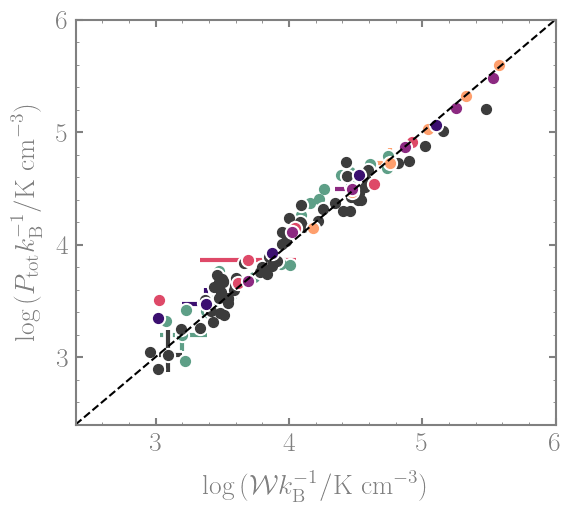

In [8]:
figW = 6
figH = 6
fig = plt.figure(figsize=(figW, figH))

topMarg = 0.2
leftMarg = 0.1
botMarg = 0.125
rightMarg = 0.1

wBetMarg = 0.03
hBetMarg = 0.01

h = (1.0-topMarg-botMarg)
w = (1.0-leftMarg-rightMarg)

### axes ###
ax0 = fig.add_axes([leftMarg, botMarg, w, h], ylim=[2.4, 6.], xlim=[2.4, 6.],
                  ylabel=r'$\log{(P_{\rm tot} k_{\rm B}^{-1}/{\rm K~cm}^{-3})}$',
                  xlabel=r'$\log{(\mathcal{W} k_{\rm B}^{-1}/{\rm K~cm}^{-3})}$')
ax0.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
                   which = 'both', direction='in')
ax0.minorticks_on()

# plot stuff
# SIMULATIONS
for color, i in zip(colors[::-1], range(len(Rbins))[::-1]):
    # one error bar
    ax0.hlines(np.log10(meddata[i]['Ptot'][-3]), np.log10(q1data[i]['Weight'][-3]),
               xmax=np.log10(q4data[i]['Weight'][-3]), lw=7, color='white', zorder=0)
    ax0.hlines(np.log10(meddata[i]['Ptot'][-3]), np.log10(q1data[i]['Weight'][-3]),
               xmax=np.log10(q4data[i]['Weight'][-3]), lw=3, color=color, zorder=0)
    
    ax0.vlines(np.log10(meddata[i]['Weight'][-3]), np.log10(q1data[i]['Ptot'][-3]),
               ymax=np.log10(q4data[i]['Ptot'][-3]), lw=7, color='white', zorder=0)
    ax0.vlines(np.log10(meddata[i]['Weight'][-3]), np.log10(q1data[i]['Ptot'][-3]),
               ymax=np.log10(q4data[i]['Ptot'][-3]), lw=3, color=color, zorder=0)

for color, i in zip(colors[::-1], range(len(Rbins))[::-1]):
    ax0.scatter(np.log10(meddata[i]['Weight']), np.log10(meddata[i]['Ptot']), s=100, color='white', zorder=1)
    ax0.scatter(np.log10(meddata[i]['Weight']), np.log10(meddata[i]['Ptot']), s=50, color=color, zorder=1)

ax0.plot(np.linspace(2.4, 6., 100), np.linspace(2.4, 6, 100), lw=1.5, ls='dashed', color='k')

plt.savefig(
    './pressure-vs-weight.pdf',
    bbox_inches='tight',
    format='pdf'
)

plt.show()